In [1]:
import xml.etree.ElementTree as ET
import os as os
from PIL import Image
import numpy as np
import torch
import os
import sys
import cv2
import torch
import random
import numbers
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import randperm
from torch._utils import _accumulate
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from skimage import io, transform
import sklearn.metrics as skm
from scipy.spatial import distance
np.set_printoptions(threshold=sys.maxsize)
import torch.optim as optim
from tqdm import tqdm as tqdm
# import tqdm.notebook  as tqdm
import imutils

f= open("../log.txt.","w+")

In [2]:
class BlobTrainDataset(Dataset):
    
    def __init__(self, path, transform = None):
        
        self.path = path 
        self.transform = transform
        self.file_list = []
        self.xml_path = ""
        for file in os.listdir(path):
            #if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
            if(file.endswith(".png")):
                self.xml_path = file.replace(".png",".xml")
            elif(file.endswith(".jpg")):
                self.xml_path = file.replace(".jpg",".xml")
            elif(file.endswith(".jpeg")):
                self.xml_path = file.replace(".jpeg",".xml")
                
            if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
                #print(os.path.join(self.path, self.xml_path))
                if os.path.exists(os.path.join(self.path, self.xml_path)):
                    self.file_list.append(file)
                
    def __len__(self):
        
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        path = os.path.join(self.path, self.file_list[index])
        #print(self.file_list[index])
        image = Image.open(path)
        
        if(path.endswith(".png")):
            annotation = ET.parse(path.replace(".png",".xml")).getroot()
        elif(path.endswith(".jpg")):
            annotation = ET.parse(path.replace(".jpg",".xml")).getroot()
        elif(path.endswith(".jpeg")):
            annotation = ET.parse(path.replace(".jpeg",".xml")).getroot()
            
        anno_detail = []
        
        for element in annotation.findall("object"):
            anno_bound_box = element.find("bndbox")
            anno_detail.append(get_bounding_box(anno_bound_box))
        
        data_dict = {"image" : image, "data" : anno_detail}
        
        if(self.transform):
            
            if(type(self.transform) is not list):
                self.transform = [self.transform]
            
            for idx in range(len(self.transform)):
                data_dict = self.transform[idx](data_dict)
        
        image_size = data_dict["image"].shape
        
        heatmap_placeholder = torch.zeros([3, int(image_size[1]/4), int(image_size[2]/4)])
        
        object_counter = 0
        
        for obj in annotation.findall("object"):
            
            label = obj.find("name").text
            
            image_heatmap = heatmap(data_dict["data"][object_counter],(image_size[1],image_size[2]))
            
            if(label == "ball"):
                heatmap_placeholder[0] += image_heatmap
            elif (label == "goalpost"):
                heatmap_placeholder[1] += image_heatmap 
            elif (label == "robot"):
                heatmap_placeholder[2] += image_heatmap 
            
            object_counter+=1
            
        dataset = {'image': data_dict['image'], 'heatmap': heatmap_placeholder}
        return dataset

In [3]:
class BlobTestDataset(Dataset):
    
    def __init__(self, path, transform = None):
        
        self.path = path 
        self.transform = transform
        self.file_list = []
        self.xml_path = ""
        for file in os.listdir(path):
            #if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
            if(file.endswith(".png")):
                self.xml_path = file.replace(".png",".xml")
            elif(file.endswith(".jpg")):
                self.xml_path = file.replace(".jpg",".xml")
            elif(file.endswith(".jpeg")):
                self.xml_path = file.replace(".jpeg",".xml")
                
            if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
                #print(os.path.join(self.path, self.xml_path))
                if os.path.exists(os.path.join(self.path, self.xml_path)):
                    self.file_list.append(file)
                
    def __len__(self):
        
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        path = os.path.join(self.path, self.file_list[index])
        #print(self.file_list[index])
        image = Image.open(path)
        print(image.size)
        if(path.endswith(".png")):
            annotation = ET.parse(path.replace(".png",".xml")).getroot()
        elif(path.endswith(".jpg")):
            annotation = ET.parse(path.replace(".jpg",".xml")).getroot()
        elif(path.endswith(".jpeg")):
            annotation = ET.parse(path.replace(".jpeg",".xml")).getroot()
            
        ball_detail = []
        goalpost_detail = []
        robot_detail = []
        
        for element in annotation.findall("object"):
            
            anno_bound_box = element.find("bndbox")
            label = element.find("name").text
            
            if(label == "ball"):
                ball_detail.append(get_bounding_box(anno_bound_box))
            
            elif(label == "goalpost"):
                goalpost_detail.append(get_bounding_box(anno_bound_box))
                
            elif(label == "robot"):
                robot_detail.append(get_bounding_box(anno_bound_box))
                
        dataset = {"image" : image,
                   "ball_detail" : ball_detail,
                   "goalpost_detail" : goalpost_detail,
                   "robot_detail" : robot_detail}
        
        if(self.transform):
            
            if(type(self.transform) is not list):
                self.transform = [self.transform]
            
            for idx in range(len(self.transform)):
                dataset = self.transform[idx](dataset)
                
        return dataset
    

In [4]:
class SegDataset(Dataset):
    
    def __init__(self, path, transform = None):
        
        self.path = path 
        self.transform = transform
        self.file_list = []
        self.target_image = ""
        self.image_path = path + "/image/"
        self.target_path = path + "/target/"

        for file in os.listdir(self.image_path):
            if(file.endswith(".jpg")):
                self.target_image = file.replace(".jpg",".png")
                if os.path.exists(os.path.join(self.target_path, self.target_image)):
                    self.file_list.append(file)
                    
    def __len__(self):
        
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        file_name = self.file_list[index]
        
        image = torch.FloatTensor(self.load_image(self.image_path + "/" + file_name))
        target = torch.FloatTensor(self.load_mask(self.target_path + "/" +  file_name.replace(".jpg",".png")))
        
        return image, target
        
    def load_image(self, path=None):
        
        raw_image = Image.open(path).convert('RGB')
        #raw_image = np.transpose(raw_image.resize((480, 640)), (2,1,0))
        raw_image = F.resize(raw_image, (480, 640))
        #raw_image = F.vflip(raw_image)
        imx_t = np.array(raw_image, dtype=np.float32)/255.0
        imx_t = np.transpose(imx_t, (2, 0, 1))
        return imx_t
    
    def load_mask(self, path=None):
        
        raw_image = Image.open(path)     
        raw_image = np.array(raw_image)
        raw_image[raw_image == 1] = 3    #change ball to ground
        raw_image[raw_image == 2] = 1
        raw_image[raw_image == 3] = 2
#         raw_image = F.resize(Image.fromarray(raw_image), (120, 160))
        imx_t = cv2.resize(raw_image, dsize=(160, 120), interpolation=cv2.INTER_NEAREST)
        imx_t = np.array(imx_t)
#         imx_t[imx_t == 1] = 3    #change ball to ground
#         imx_t[imx_t == 2] = 1
#         imx_t[imx_t == 3] = 2
        #print("Label :  ",np.array(raw_image))
        #imx_t[imx_t==255] = 3
        imx_t = np.transpose(imx_t, (0, 1))
#         imx_t = np.array(raw_image, dtype=np.float32)/255.0
        return imx_t



In [5]:
class ToTensor(object):
    
    def __call__(self, data_dict): 
        transformed_dict = dict()
        
        for key in data_dict.keys():
            
            if key == 'image':
                image = data_dict[key]
                image = F.to_tensor(image)
                transformed_dict[key] = image
            else:
                dtls = torch.FloatTensor(data_dict[key])
                transformed_dict[key] = dtls
                
        return transformed_dict

In [6]:
class Rescale(object):
    
    def __init__(self, output_size):
        
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data_dict):
        
        transformed_dict = dict()
        
        #print("Rescale Bounding Box")
        
        image = data_dict['image']
        w, h = image.size
        
        #image.show()
        #print("Old iMage dimension : ",w,"x",h)
        
        if isinstance(self.output_size, int):        
            
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
                
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        
        for key in data_dict.keys():
            
            if key == 'image':
                img = F.resize(image, (new_h, new_w))
                
                #img.show()
                #print("new iMage dimension : ",new_w,"x",new_h)
                
                transformed_dict[key] = img
            else:
                bounding_box = data_dict[key]
                
                #print(bounding_box)
                
                for i, dtls in enumerate(bounding_box):
    
                    #print("=====================Old Bounding Box================")
                    #print_bounding_box(dtls)
            
                    bounding_box[i][0] = np.round(dtls[0] * np.array([new_w / w, new_h / h]), 0)
                    bounding_box[i][1] = np.round(dtls[1] * np.array([new_w / w, new_h / h]), 0)
                    bounding_box[i][3] = np.abs([dtls[0, 0]-dtls[1, 0], dtls[0, 1]-dtls[1, 1]])
                    bounding_box[i][2] = np.array([dtls[0, 0]+dtls[3, 0]/2, dtls[0, 1]+dtls[3, 1]/2])
                    
                    #print("=====================New Bounding Box================")
                    #print_bounding_box(bounding_box[i])

                transformed_dict[key] = bounding_box
        return transformed_dict

In [7]:
class RandomVerticalFlip(object):
    
    def __init__(self, p=0.5):
        
        self.p = p

    def __call__(self, data_dict):
        
        transformed_dict = dict()
        
        #print("Verticle Flip Bounding Box")
        
        image = data_dict['image']
        w, h = image.size
        
        #print("Flipped image dimension : ",w,"x",h)
        
        if random.random() < self.p:
            
            for key in data_dict.keys():
                
                if key == 'image':
                    image = F.vflip(image)
                    
                    #image.show()
                    
                    transformed_dict[key] = image
                else:
                    bounding_box = data_dict[key]
                    
                    #print(bounding_box)
                    
                    for i, dtls in enumerate(bounding_box):
                        
                        #print("=====================Old Bounding Box================")
                        #print_bounding_box(dtls)
                        
                        if dtls[2][0] > 0 and dtls[2][1] > 0:
                            bounding_box[i][0] = np.array([dtls[0, 0], h - dtls[1, 1]])
                            bounding_box[i][1] = np.array([dtls[1, 0], bounding_box[i][0, 1] + dtls[3, 1] ])
                            bounding_box[i][3] = np.abs([dtls[0, 0]-dtls[1, 0], dtls[0, 1]-dtls[1, 1]])
                            bounding_box[i][2] = np.array([dtls[0, 0]+dtls[3, 0]/2, dtls[0, 1]+dtls[3, 1]/2])
                            
                            #print("=====================New Bounding Box================")
                            #print_bounding_box(bounding_box[i])
                            
                    transformed_dict[key] = bounding_box
        else:
            return data_dict
        
        return transformed_dict

In [8]:
class RandomHorizontalFlip(object):
    
    def __init__(self, p=0.5):
        
        self.p = p

    def __call__(self, data_dict):
        
        transformed_dict = dict()
        
        #print("Horizontal Flip Bounding Box")
        
        image = data_dict['image']
        w, h = image.size
        
        #print("Flipped image dimension : ",w,"x",h)
        
        if random.random() < self.p:
            
            for key in data_dict.keys():
                
                if key == 'image':
                    image = F.hflip(image)
                    
                    #image.show()
                    
                    transformed_dict[key] = image
                else:
                    bounding_box = data_dict[key]
                    
                    #print(bounding_box)
                    
                    for i, dtls in enumerate(bounding_box):
                        
                        #print("=====================Old Bounding Box================")
                        #print_bounding_box(dtls)
                        
                        if dtls[2][0] > 0 and dtls[2][1] > 0:
                            bounding_box[i][0] = np.array([w - (dtls[0, 0] + dtls[3, 0]), dtls[0, 1]])
                            bounding_box[i][1] = np.array([bounding_box[i][0, 0] + dtls[3, 0], dtls[1, 1] ])
                            bounding_box[i][3] = np.abs([dtls[0, 0]-dtls[1, 0], dtls[0, 1]-dtls[1, 1]])
                            bounding_box[i][2] = np.array([dtls[0, 0]+dtls[3, 0]/2, dtls[0, 1]+dtls[3, 1]/2])
                            
                            #print("=====================New Bounding Box================")
                            #print_bounding_box(bounding_box[i])
                            
                    transformed_dict[key] = bounding_box
        else:
            return data_dict
        
        return transformed_dict

In [9]:
class Normalize(object):
    
    def __init__(self, mean, std):
    
        self.mean = mean
        self.std = std
        
    def __call__(self, data_dict):
        
        bounding_box = dict()
        
        for key in data_dict.keys():
            
            if key == 'image':
                image = data_dict[key]
                bounding_box[key] = F.normalize(image, self.mean, self.std)
            else:
                bounding_box[key] = data_dict[key]
                
        return bounding_box

In [10]:
class Lambda(object):

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + \
            " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [11]:
class ColorJitter(object):

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError(
                    "If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError(
                    "{} values should be between {}".format(name, bound))
        else:
            raise TypeError(
                "{} should be a single number or a list/tuple with lenght 2.".format(name))

        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):

        tforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            tforms.append(
                Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            tforms.append(
                Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            tforms.append(
                Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            tforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(tforms)
        transform = transforms.Compose(tforms)

        return transform

    def __call__(self, sample):

        items = dict()
        for key in sample.keys():
            if key == 'image':
                image = sample[key]
                transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
                items[key] =  transform(image)
            else:
                items[key] = sample[key]
        return items

In [12]:
def get_bounding_box(bound_box):
    
    xmin = int(bound_box.find('xmin').text)
    ymin = int(bound_box.find('ymin').text)
    xmax = int(bound_box.find('xmax').text)
    ymax = int(bound_box.find('ymax').text)
    return np.array((xmin,ymin,xmax,ymax,(xmin+xmax)/2,(ymin+ymax)/2,np.abs(xmax-xmin),np.abs(ymin-ymax))).reshape(-1,2)

def scaled_bounding_box(bound_box, scale):
    
    bound_box[0] = bound_box[0]/scale
    bound_box[1] = bound_box[1]/scale
    
    bound_box[2][0] = (bound_box[0, 0]+bound_box[1, 0]) /2.0
    bound_box[2][1] = (bound_box[0, 1]+bound_box[1, 1])/2.0
    
    bound_box[3][0] = torch.abs(bound_box[0, 0]-bound_box[1, 0])
    bound_box[3][1] = torch.abs(bound_box[0, 1]-bound_box[1, 1])
    return bound_box

In [13]:
def heatmap(bound_box, img_size):
    
    bound_box.float()
    
    height = bound_box[3][0]
    width  = bound_box[3][1]
    
    bound_box = scaled_bounding_box(bound_box, 4.0)
    
    image_heatmap = torch.zeros(int(img_size[0]/4),int(img_size[1]/4))
    
    k_size=8
    kernel = cv2.getGaussianKernel(k_size, 8)
    kernel = np.dot(kernel, kernel.T)
    kernel *= 100
    
    if bound_box[2][1].item()+k_size > image_heatmap.shape[0]-1:
        y_begin = image_heatmap.shape[0]-1-k_size         
    else:
        y_begin = int(bound_box[2][1].item())

    if bound_box[2][0].item()+k_size > image_heatmap.shape[1]-1:
        x_begin = image_heatmap.shape[1]-1-k_size
    else:
        x_begin = int(bound_box[2][0].item())
        
    y_end = y_begin + (k_size)
    x_end = x_begin + (k_size)
    image_heatmap[y_begin : y_end, x_begin : x_end] = torch.from_numpy(kernel)
    return image_heatmap

In [14]:
def print_dataloader(loader, num_of_image = 1, avDev = torch.device("cuda")):
    
    k=0
    for j,train_data in enumerate(loader):
        
        images = train_data['image'].to(avDev)
        heatmaps = train_data['heatmap'].to(avDev)
        plt.figure(figsize=(40,20))
        plt.subplot(1,4,1)
        plt.title('Train image' + str(k))
        plt.imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)))
        plt.subplot(1,4,2)
        plt.title('ball')
        plt.imshow(heatmaps[0][0].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(1,4,3)
        plt.title('goalpost')
        plt.imshow(heatmaps[0][1].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(1,4,4)
        plt.title('robot')
        plt.imshow(heatmaps[0][2].cpu().detach().numpy(), cmap= 'gray')
        plt.show()
        
        k+=1
        
        if k == num_of_image:
            return
        
    return

In [15]:
def blob_test(model, test_loader, device):
    
    model.eval()
    
    test_loss = 0
    recall = torch.zeros(3)
    tp = torch.zeros(3)
    fp = torch.zeros(3)
    fn = torch.zeros(3)
    fdr = torch.zeros(3)
    acc = torch.zeros(len(test_loader))

    for i, test_data in enumerate(test_loader):

        images = test_data["image"].to(device)
        ball = test_data["ball_detail"].to(device)
        goalpost = test_data["goalpost_detail"].to(device)
        robot = test_data["robot_detail"].to(device)

        images.requires_grad_(False)
        ball.requires_grad_(False)
        goalpost.requires_grad_(False)
        robot.requires_grad_(False)

        output = model(images)

        batch_len = output.shape[0]

        for j in range(batch_len):

            ball_center = center_of_shape(output[j][0].cpu().detach().numpy())
            b_tp, b_fn, b_fp = metric_calculation(ball[j], ball_center, 4)
            tp[0] += b_tp
            fp[0] += b_fp
            fn[0] += b_fn

            goalpost_center = center_of_shape(output[j][1].cpu().detach().numpy())
            g_tp, g_fn, g_fp = metric_calculation(goalpost[j], goalpost_center, 4)
            tp[1] += g_tp
            fp[1] += g_fp
            fn[1] += g_fn

            robot_center = center_of_shape(output[j][2].cpu().detach().numpy())
            r_tp, r_fn, r_fp = metric_calculation(robot[j], robot_center, 4)
            tp[2] += r_tp
            fp[2] += r_fp
            fn[2] += r_fn

        acc[i] = torch.mean(tp) / (torch.mean(tp) + torch.mean(fn) + torch.mean(fp))

    for i in range(3):
        recall[i] = (tp[i])/(tp[i]+fn[i])
        fdr[i] = (fp[i])/(fp[i]+tp[i])
        
    print("Recall of Ball "+str(round(float(recall[0]),2)) )
    print("Recall of Goalpost "+str(round(float(recall[1] ),2)))
    print("Recall of Robot "+str(round(float(recall[2]),2)) )

    print("FDR of Ball "+str(round(float(fdr[0] ),2)))
    print("FDR of Goalpost "+str(round(float(fdr[1]),2)))
    print("FDR of Robot "+str(round(float(fdr[2]),2)))

    total_recall = torch.mean(recall)
    total_fdr = torch.mean(fdr)

    print("Total recall "  +str(round(float(total_recall),2)))
    print("Total FDR "  +str(round(float(total_fdr),2)))
    print("Accuracy " +str(round(float(acc.mean()),2)))

In [16]:
def blob_test_output(model, test_loader, avDev):
    
    k=1
    for j,test_data in enumerate(test_loader):

        images = test_data["image"].to(avDev)
        ball = test_data["ball_detail"].to(avDev)
        goalpost = test_data["goalpost_detail"].to(avDev)
        robot = test_data["robot_detail"].to(avDev)

        images.requires_grad_(False)
        ball.requires_grad_(False)
        goalpost.requires_grad_(False)
        robot.requires_grad_(False)

        batch = test_data['image'].shape[0]

        for i in range(batch):
            k += 1
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.title('Test image' + str(k))
            plt.imshow(images[i][0].cpu())
            out = model(images)
            plt.subplot(1,2,2)
            plt.title('Detected Object')
           # print(out[i].cpu().detach().numpy())
            plt.imshow([1 , 1 , 1] - np.transpose(out[i].cpu().detach().numpy(), (1, 2, 0)))
#             plt.title('Ball')
#             plt.imshow(out[i][0].cpu().detach().numpy(), cmap= 'gray')
#             plt.subplot(2,3,3)
#             plt.title('Goalpost')
#             plt.imshow(out[i][1].cpu().detach().numpy(), cmap= 'gray')
#             plt.subplot(2,3,5)
#             plt.title('Robot')
#             plt.imshow(out[i][2].cpu().detach().numpy(), cmap= 'gray')
            plt.show()

In [35]:
def train_model(model, mode, train_loader, criterion_blob, criterion_seg, optimizer, device):
    
    model.train()
    train_loss_blob = 0.0
    train_loss_seg = 0.0
    loss_blob = 0
    loss_seg = 0
    train_loss = 0.0
    
#     if(mode == "blob"):
#         train_loader = train_loader[0]
    
#     else:
#         train_loader = train_loader[1]
    
    for i_batch, sample_batched in enumerate(tqdm(train_loader)):
        if sample_batched.__class__.__name__ == "dict" :
            image = sample_batched['image'].to(device)
            label = sample_batched['heatmap'].to(device)
            output = model(image)
            optimizer.zero_grad()
            loss_blob = criterion_blob(output, label)
            
        else:
            image = sample_batched[0].to(device)
            label = sample_batched[1].to(device)
            label = torch.tensor(label, dtype=torch.long, device=device)
            output = model(image)
            optimizer.zero_grad()
            #m = nn.Softmax(dim=1)
            loss_seg = criterion_seg(output, label)
        
        
        #print("Output Size = ",output.size(),"  Label Size", label.size())
        train_loss += (loss_blob + loss_seg)
        
        if sample_batched.__class__.__name__ == "dict" :
            loss_blob.backward()
            
        else:
            loss_seg.backward()
        
        optimizer.step()
          
    return train_loss.item(), model

In [36]:
def center_of_shape(image):
    
    centers = []
    
    kernel = np.ones((3, 3), np.uint8)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    threshold = cv2.threshold(blurred,0.7, 255, cv2.THRESH_BINARY)[1]
    
    contours = cv2.findContours(threshold.copy().astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    
    for contour in contours:
        
        M = cv2.moments(contour)
        if(M["m00"]>0):
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX,cY))
            
    return torch.FloatTensor(centers)

In [37]:
def metric_calculation(actual_boxes, output_boxes, threshold_distance):
    
    num_legal_boxes = 0
    num_output_box = len(output_boxes)
    
    tp, fn, fp = 0, 0, 0
    
    for box_num in range(actual_boxes.size(0)):
        
        if(actual_boxes[box_num][2][0] > 0 or actual_boxes[box_num][2][0] >0):
            num_legal_boxes +=1
            
    flag_actual_boxes = np.zeros(num_legal_boxes)
    
    for obox_num in range(num_output_box):
        
        found = -1
        
        for abox_num in range(num_legal_boxes):
           
            a_center = actual_boxes[abox_num][2]/4.0
            o_detected = False
            o_center = output_boxes[obox_num]
            
            if(o_center[0] > 0 or o_center[1] > 0):
                o_detected = True
                
            if(o_detected):
                dist = distance.euclidean(a_center.cpu(),o_center.cpu())
                
                if(dist < threshold_distance):
                    tp += 1
                    found = abox_num
                    break
        
        if(found == -1):
            fp +=1
        
        else:
            flag_actual_boxes[found] = 1
        
    fn = np.count_nonzero(flag_actual_boxes == 0)
        
    return tp, fn, fp
    
    

In [38]:
class LocationAwareConv2d(torch.nn.Conv2d):
    
    def __init__(self,locationAware,gradient,w,h,in_channels = 256, out_channels=3, kernel_size=1, stride=1, padding=0, bias=True):
        
        super().__init__(in_channels = 256, out_channels=3, kernel_size=1, stride=1, padding=0, bias=True)
        
        if locationAware:
            self.locationBias=torch.nn.Parameter(torch.zeros(w,h,3))
            self.locationEncode=torch.autograd.Variable(torch.ones(w,h,3))
            
            if gradient:
                for i in range(w):
                    self.locationEncode[i,:,1]=self.locationEncode[:,i,0]=i/float(w-1)
        
        self.up=torch.nn.Upsample(size=(w,h), mode='bilinear', align_corners=False)
        self.w=w
        self.h=h
        self.locationAware=locationAware
        
    def forward(self,inputs):
        
        if self.locationAware:
            if self.locationBias.device != inputs.device:
                self.locationBias=self.locationBias.to(inputs.get_device())
                
            if self.locationEncode.device != inputs.device:
                self.locationEncode=self.locationEncode.to(inputs.get_device())
                
            b=self.locationBias*self.locationEncode
            
        convRes=super().forward(inputs)
        
        if convRes.shape[2]!=self.w and convRes.shape[3]!=self.h:
            convRes=self.up(convRes)
            
        if self.locationAware:
            return convRes+b[:,:,0]+b[:,:,1]+b[:,:,2]
        
        else:
            return convRes

In [39]:
"""
NimbRoNet2 Model Class
"""

class NimbRoNet2(nn.Module):
    def __init__(self):
        super(NimbRoNet2, self).__init__()
        model = models.resnet18(pretrained=True)
        
        """
        Encoder Block
        """
        self.e_block1 = nn.Sequential(*list(model.children())[0:5])
        self.conv_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        
        self.e_block2 = nn.Sequential(*list(model.children())[5:6])
        self.conv_1_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
        
        self.e_block3 = nn.Sequential(*list(model.children())[6:7])
        self.conv_1_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
        
        self.e_block4 = nn.Sequential(*list(model.children())[7:-2])
        """
        Decoder Block
        """
        self.d_block1 = nn.Sequential(
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels = 512, out_channels=256, kernel_size=2, stride=2, padding=0, output_padding=0))
        
        self.d_block2 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(512),
                        nn.ConvTranspose2d(in_channels = 512, out_channels=256, kernel_size=2, stride=2, padding=0, output_padding=0))
        
        self.d_block3 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(512),
                        nn.ConvTranspose2d(in_channels = 512, out_channels=128, kernel_size=2, stride=2, padding=0, output_padding=0))
        
        self.d_block4 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
#                         nn.ConvTranspose2d(in_channels = 256,out_channels=3, kernel_size=1, stride=1, padding=0, output_padding=0))
                        LocationAwareConv2d(True, False, 120, 160, in_channels = 256, out_channels=3, kernel_size=1, stride=1, padding=0))
        """
        Location dependent convolution
        """
        
        

    def forward(self, input):
        """
        encoder
        """
        #print("Input : ",input.shape)
        
        output = self.e_block1(input)
        #print("e_block1 : ",output.shape)
        
        res_1 = self.conv_1_1(output)
        #print("res_1 : ",res_1.shape)
        
        output = self.e_block2(output)
        #print("e_block2 : ",output.shape)
        
        res_2 = self.conv_1_2(output)
        #print("res_2 : ",res_2.shape)
        
        output = self.e_block3(output)
        #print("e_block3 : ",output.shape)
        
        res_3 = self.conv_1_3(output)
        #print("res_3 : ",res_3.shape)
        
        output = self.e_block4(output)
        #print("e_block4 : ",output.shape)
        """
        decoder
        """
        output = self.d_block1(output)
        #print("d_block1 : ",output.shape)
        
        output = torch.cat((output, res_3), 1)
        #print("d_block1 + res3 : ",output.shape)
        
        output = self.d_block2(output)
        #print("d_block2 : ",output.shape)
        
        output = torch.cat((output, res_2), 1)
        #print("d_block2 + res2 : ",output.shape)        
        
        output = self.d_block3(output)
        #print("d_block3 : ",output.shape)
        
        output = torch.cat((output, res_1), 1)
        #print("d_block3 + res1 : ",output.shape)
        
        output = self.d_block4(output)
        #print("d_block4 : ",output.shape)
        """
        Location dependent convolution
        """
        
        return output

In [40]:
from torch.utils.data.sampler import RandomSampler

class BatchSchedulerSampler(torch.utils.data.sampler.Sampler):
    """
    iterate over tasks and provide a random batch per task in each mini-batch
    """
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.number_of_datasets = len(dataset.datasets)

    def __len__(self):
        return len(self.dataset) * self.number_of_datasets
    

    def __iter__(self):
        samplers_list = []
        sampler_iterators = []
        datasets_length = []
        for dataset_idx in range(self.number_of_datasets):
            cur_dataset = self.dataset.datasets[dataset_idx]
            sampler = RandomSampler(cur_dataset)
            samplers_list.append(sampler)
            cur_sampler_iterator = sampler.__iter__()
            sampler_iterators.append(cur_sampler_iterator)
            datasets_length.append(len(cur_dataset))

        push_index_val = [0] + self.dataset.cumulative_sizes[:-1]
        step = self.batch_size * self.number_of_datasets
        samples_to_grab = self.batch_size
        largest_dataset_index = torch.argmax(torch.as_tensor(datasets_length)).item()
        # for this case we want to get all samples in dataset, this force us to resample from the smaller datasets
        epoch_samples = datasets_length[largest_dataset_index] * self.number_of_datasets

        final_samples_list = []  # this is a list of indexes from the combined dataset
        for _ in range(0, epoch_samples, step):
            for i in range(self.number_of_datasets):
                cur_batch_sampler = sampler_iterators[i]
                cur_samples = []
                for _ in range(samples_to_grab):
                    try:
                        cur_sample_org = cur_batch_sampler.__next__()
                        cur_sample = cur_sample_org + push_index_val[i]
                        cur_samples.append(cur_sample)
                    except StopIteration:
                        if i == largest_dataset_index:
                            # largest dataset iterator is done we can break
                            samples_to_grab = len(cur_samples)  # adjusting the samples_to_grab
                            # got to the end of iterator - extend final list and continue to next task if possible
                            break
                        else:
                            # restart the iterator - we want more samples until finishing with the largest dataset
                            sampler_iterators[i] = samplers_list[i].__iter__()
                            cur_batch_sampler = sampler_iterators[i]
                            cur_sample_org = cur_batch_sampler.__next__()
                            cur_sample = cur_sample_org + push_index_val[i]
                            cur_samples.append(cur_sample)
                final_samples_list.extend(cur_samples)

        return iter(final_samples_list)

In [48]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

batch_size = 5

print("Device : ",avDev)
print("Python Version : ",sys.version)
print("Pytorch Version : ",torch.__version__)

Device :  cuda
Python Version :  3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Pytorch Version :  1.3.1


In [49]:
train_transforms = [Rescale((480,640)),
              RandomVerticalFlip(),
              RandomHorizontalFlip(),
              ColorJitter(brightness=0.5, 
                          contrast=0.5, 
                          saturation=0.5,
                          hue = 0.5),
              ToTensor(),
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

train_dataset = BlobTrainDataset(path = '../Project/data/blob/forceTrain',transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# print_dataloader(train_loader, num_of_image= 3, avDev = avDev)

print("Blob Train Dataset : ",len(train_dataset))

seg_train_dataset = SegDataset(path = '../Project/data/segmentation/dataset', transform= None)
seg_train_loader = torch.utils.data.DataLoader(dataset=seg_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

print("Segmentation Train Dataset : ",len(seg_train_dataset))

combined_train_dataset = torch.utils.data.ConcatDataset([train_dataset, seg_train_dataset])
combined_train_loader = torch.utils.data.DataLoader(dataset=combined_train_dataset, 
                                           sampler=BatchSchedulerSampler(dataset=combined_train_dataset,
                                                                       batch_size=batch_size),
                                           batch_size=batch_size,
                                           shuffle=False)

print("Combined Train Dataset : ",len(combined_train_dataset))

# for i, test_data in enumerate(seg_train_loader):

#     plt.figure(figsize=(50,25))
#     print(test_data[0].size())
#     plt.imshow(torchvision.utils.make_grid(test_data[0], nrow=5).permute(1, 2, 0))
#     plt.show()
#     plt.figure(figsize=(20,10))
# #     plt.imshow(torchvision.utils.make_grid(test_data[1], nrow=1).permute(1, 2, 0))
# #     plt.imshow(torchvision.utils.make_grid(test_data[1][0], nrow=5).permute(1, 2, 0))
#     plt.imshow(test_data[1][0].cpu().detach().numpy(), interpolation='nearest')
#     print(test_data[1][0].cpu().detach().numpy().size)
#     plt.show()
# #     print(np.array(test_data[1][0]))
#     raise KeyboardInterrupt

Blob Train Dataset :  3598
Segmentation Train Dataset :  1108
Combined Train Dataset :  4706


In [57]:
blob_data = 0
seg_data = 0
for i, batch in enumerate(tqdm(combined_train_loader)):
    if i<=20:
        #     f.write(str(i)+" Batch \n")
        #     if batch.__class__.__name__ == "dict" :
        #         f.write("Dict - "+str(len(batch))+"\n")
        #         blob_data += len(batch)
        #     else:
        #         f.write("List - "+str(len(batch))+"\n")
        #         seg_data += len(batch)
        if batch.__class__.__name__ == "dict" :
            print("dict")
        else:
            print("List")
    else:
        break


  0%|          | 1/1883 [00:00<06:39,  4.71it/s]

dict
List



  0%|          | 3/1883 [00:00<05:53,  5.31it/s]

dict
List



  0%|          | 5/1883 [00:00<05:20,  5.87it/s]

dict
List



  0%|          | 7/1883 [00:00<04:52,  6.42it/s]

dict
List



  0%|          | 9/1883 [00:01<04:39,  6.71it/s]

dict
List



  1%|          | 11/1883 [00:01<04:24,  7.08it/s]

dict
List



  1%|          | 13/1883 [00:01<04:14,  7.35it/s]

dict
List



  1%|          | 15/1883 [00:01<04:09,  7.48it/s]

dict
List



  1%|          | 17/1883 [00:02<04:10,  7.46it/s]

dict
List



  1%|          | 19/1883 [00:02<04:08,  7.51it/s]

dict
List



  1%|          | 21/1883 [00:02<04:06,  7.56it/s]

dict


In [44]:
f.close()
print("Blob ",blob_data," Seg ",seg_data)

Blob  0  Seg  0


In [45]:
model = NimbRoNet2()
model.to(avDev)

criterion_blob = nn.MSELoss()
criterion_seg = nn.CrossEntropyLoss()

criterion_blob.to(avDev)
criterion_seg.to(avDev)

optimizer = optim.Adam([
                        {"params":model.e_block1.parameters(), "lr": 0.000001},
                        {"params":model.e_block2.parameters(), "lr": 0.000001},
                        {"params":model.e_block3.parameters(), "lr": 0.000001},
                        {"params":model.e_block4.parameters(), "lr": 0.000001},
                        {"params":model.d_block1.parameters()},
                        {"params":model.d_block2.parameters()},
                        {"params":model.d_block3.parameters()},
                        {"params":model.d_block4.parameters()},
                        {"params":model.conv_1_1.parameters()},
                        {"params":model.conv_1_2.parameters()},
                        {"params":model.conv_1_3.parameters()}], lr=0.001)

# checkpoint = torch.load("../model.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# no_epoch = checkpoint['epoch']
# print("No of epoch : ",no_epoch)
# train_loss_1 = checkpoint['train_loss1']

In [46]:
total_loss = 0.0
loss_details = [None]*100
train_loss = 0.0

combined_loader = [train_loader, seg_train_loader]

for epoch in range(9):

    print("epoch",epoch)
    train_loss, model = train_model(model, "seg", combined_train_loader, criterion_blob, criterion_seg, optimizer, avDev)
    loss_details[epoch] = train_loss
    print("train loss",train_loss)
    total_loss += train_loss

  0%|          | 0/1883 [00:00<?, ?it/s]

epoch 0


 76%|███████▋  | 1438/1883 [12:11<03:47,  1.96it/s]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss1': loss_details,
#             }, "../model.pth")

Accuracy :  83.19895833333334


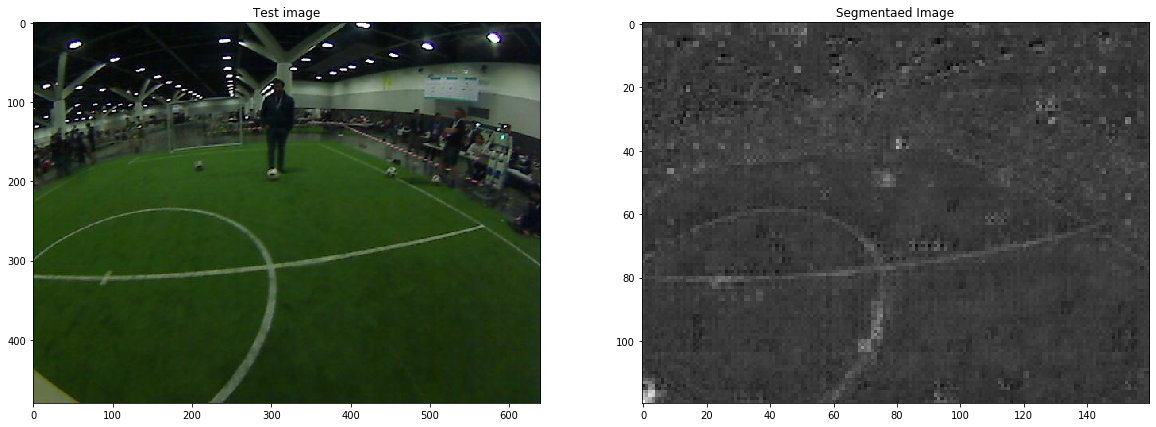

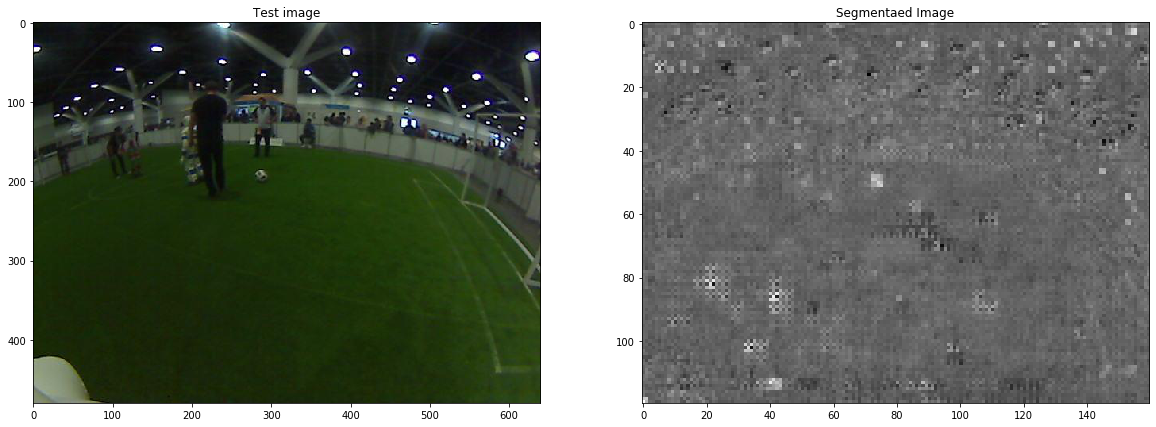

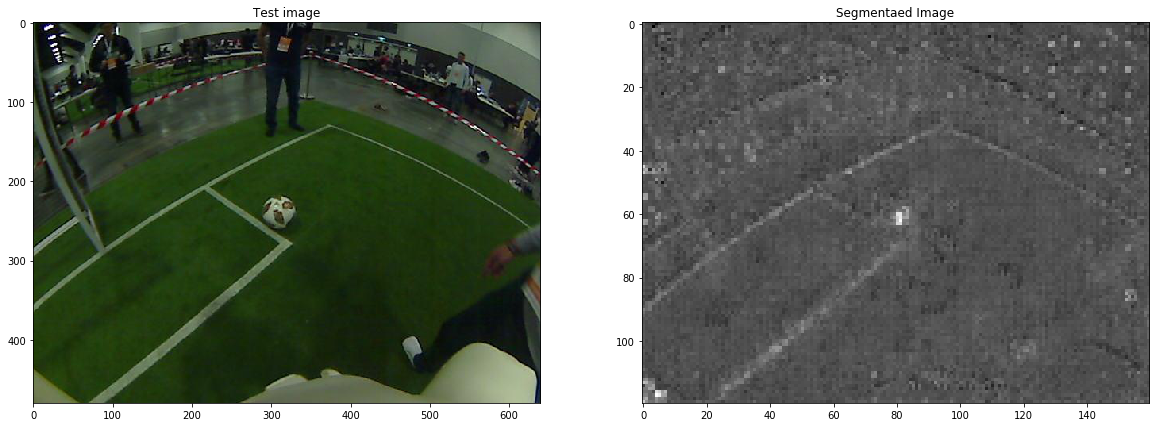

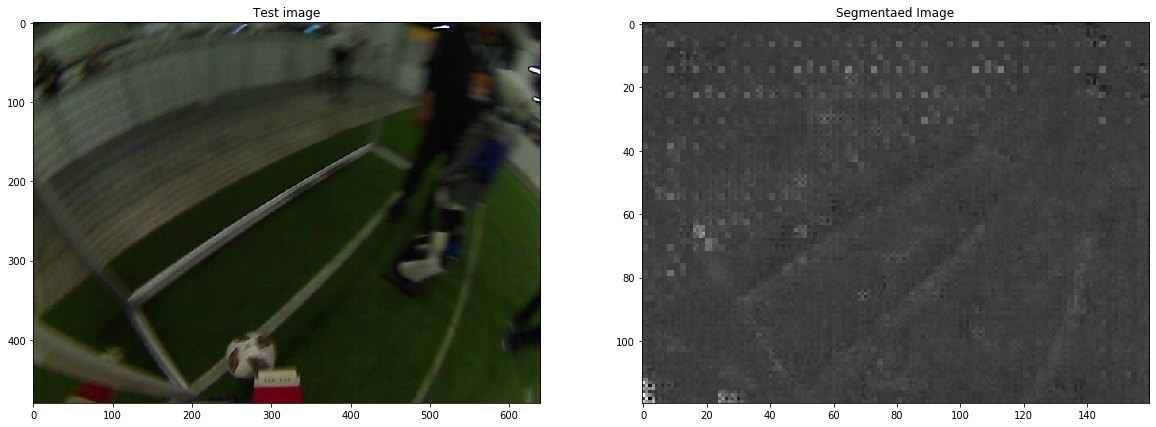

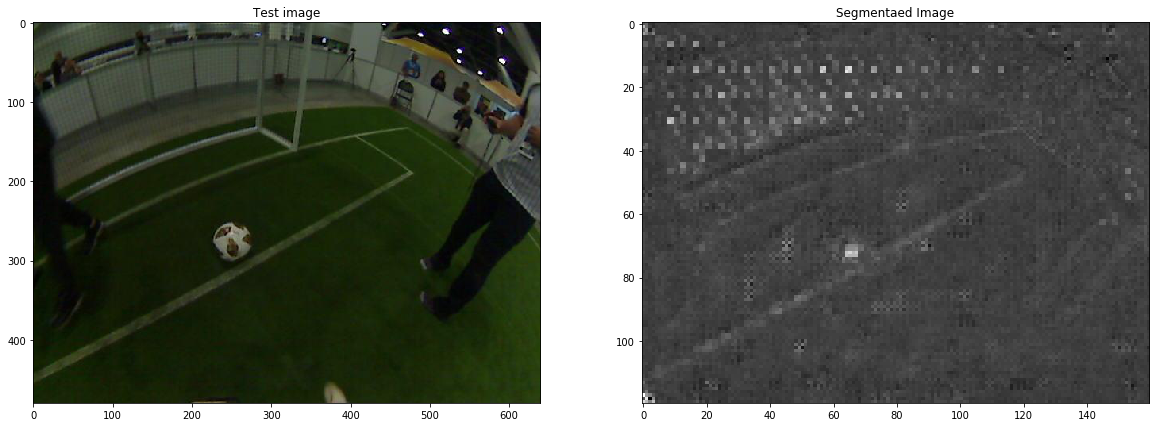

In [47]:
test_transforms = [Rescale((480,640)),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

test_dataset = BlobTestDataset(path = '../Project/data/blob/forceTest',transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1, 
                                           shuffle=True)

seg_test_dataset = SegDataset(path = '../Project/data/segmentation/forceTrain',transform=None)
seg_test_loader = torch.utils.data.DataLoader(dataset=seg_test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# blob_test(model, test_loader, avDev)
# blob_test_output(model, test_loader, avDev)

total_test = 0
correct_test = 0

for i, test_data in enumerate(seg_test_loader):
    if(i <= 0):
        images = test_data[0].to(avDev)
        target = test_data[1].to(avDev)

        output = model(images)
        
        _,predicted = torch.max(output.data, 1)
        total_test += target.nelement()
        correct_test += predicted.eq(target.data).sum().item()
        test_accuracy = 100 * correct_test / total_test
        print("Accuracy : ", test_accuracy)
        
        for i in range(output.shape[0]):
        
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.title('Test image')
            #print(images[i].size())
            plt.imshow(np.transpose(images[i].cpu().detach().numpy(), (1, 2, 0)))
            plt.subplot(1,2,2)
            plt.title('Segmentaed Image')
            plt.imshow(np.transpose(output[i].cpu().detach().numpy(), (1, 2, 0)).mean(axis = 2), cmap = 'gray')
            #channel 0 background; 1 line; 2 ground
    #         plt.imshow(torchvision.utils.make_grid(output.cpu().detach()[0][2,:,:], nrow=5).permute(1, 2, 0))
            #plt.imshow(torchvision.utils.make_grid([1, 1, 1] - output.cpu().detach().numpy(), nrow=5).permute(1, 2, 0))
            plt.show()
    else:
        break